# Improved Language Modeling

<b>Name:</b> Abhinav Lugun  <b>Student Id:</b> st122322

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext, datasets, math
from torchtext.vocab import vocab as torchTextVocab
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import random, math, time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


# 1) Load Dataset

In [3]:
dataset = load_dataset("lvwerra/codeparrot-clean", split="train", streaming=True)

Using custom data configuration lvwerra--codeparrot-clean-fb728533b9673c8b


In [4]:
iter_dataset = iter(dataset)

In [5]:
list(next(iter_dataset))

['repo_name',
 'path',
 'copies',
 'size',
 'content',
 'license',
 'hash',
 'line_mean',
 'line_max',
 'alpha_frac',
 'autogenerated']

# 2) Extracting data related to pytorch code

All repo containing Pytorch code will be extracted since the main emphasis is given for suggesting Pytorch code for code autocomplete. Since the repo also contain other parts related to such as numpy, and matplotlib, the model will learn to suggest code completion for those parts also.

In [6]:
pytorch_related = []

In [7]:
threshold = 500
count = 0

for repo in iter_dataset:
    if 'torch' in repo['repo_name']:
        pytorch_related.append(repo['content'])
        count += 1
        
        if count % 100 == 0:
            print(count)
        
        if count == threshold:
            break

100
200
300
400
500


In [66]:
idx = 0
print(pytorch_related[idx][:1100])

# Copyright 2020 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import unittest

import pytest

from transformers import pipeline
from transformers.testing_utils import is_pipeline_test, is_torch_available, require_torch, slow

from .test_pipelines_common import MonoInputPipelineCommonMixin


if is_torch_available():
    from transformers.models.mbart import MBart50TokenizerFast, MBartForConditionalGeneration


class TranslationEnToDePipelineTests(MonoI

### Splitting into train, validation, and test sets

In [67]:
Len = len(pytorch_related)

In [68]:
end   = int(0.7 * Len)
train = pytorch_related[:end]

start = int(0.7 * Len)
end   = int(0.8 * Len)
valid = pytorch_related[start: end]

start = int(0.8 * Len)
test  = pytorch_related[start:]

In [69]:
len(train), len(valid), len(test)

(350, 50, 100)

In [70]:
print(train[0][:1300])

# Copyright 2020 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import unittest

import pytest

from transformers import pipeline
from transformers.testing_utils import is_pipeline_test, is_torch_available, require_torch, slow

from .test_pipelines_common import MonoInputPipelineCommonMixin


if is_torch_available():
    from transformers.models.mbart import MBart50TokenizerFast, MBartForConditionalGeneration


class TranslationEnToDePipelineTests(MonoI

In [71]:
from torchdata.datapipes.iter import IterableWrapper

In [72]:
train = IterableWrapper(train)
valid = IterableWrapper(valid)
test  = IterableWrapper(test)

In [73]:
len(list(iter(train))), len(list(iter(valid))), len(list(iter(test)))

(350, 50, 100)

# 3) Processing

## Tokenizing

To tokenize Python code accurately, 'tokenize' module was used. It is meant to provide a lexical scanner for Python code. However, in this case, the module was extremely useful since apart from returning tokens, it also return its type which made it possible to treadtnumbers and strings alike. Also during tokenizing, comments were excluded since they are not useful for training the model. 

https://stackoverflow.com/questions/62166362/how-to-tokenize-python-code-using-the-tokenize-module

In [74]:
import tokenize
import io

In [75]:
tok_name = tokenize.tok_name

In [76]:
print(tok_name)

{0: 'ENDMARKER', 1: 'NAME', 2: 'NUMBER', 3: 'STRING', 4: 'NEWLINE', 5: 'INDENT', 6: 'DEDENT', 7: 'LPAR', 8: 'RPAR', 9: 'LSQB', 10: 'RSQB', 11: 'COLON', 12: 'COMMA', 13: 'SEMI', 14: 'PLUS', 15: 'MINUS', 16: 'STAR', 17: 'SLASH', 18: 'VBAR', 19: 'AMPER', 20: 'LESS', 21: 'GREATER', 22: 'EQUAL', 23: 'DOT', 24: 'PERCENT', 25: 'LBRACE', 26: 'RBRACE', 27: 'EQEQUAL', 28: 'NOTEQUAL', 29: 'LESSEQUAL', 30: 'GREATEREQUAL', 31: 'TILDE', 32: 'CIRCUMFLEX', 33: 'LEFTSHIFT', 34: 'RIGHTSHIFT', 35: 'DOUBLESTAR', 36: 'PLUSEQUAL', 37: 'MINEQUAL', 38: 'STAREQUAL', 39: 'SLASHEQUAL', 40: 'PERCENTEQUAL', 41: 'AMPEREQUAL', 42: 'VBAREQUAL', 43: 'CIRCUMFLEXEQUAL', 44: 'LEFTSHIFTEQUAL', 45: 'RIGHTSHIFTEQUAL', 46: 'DOUBLESTAREQUAL', 47: 'DOUBLESLASH', 48: 'DOUBLESLASHEQUAL', 49: 'AT', 50: 'ATEQUAL', 51: 'RARROW', 52: 'ELLIPSIS', 53: 'COLONEQUAL', 54: 'OP', 55: 'AWAIT', 56: 'ASYNC', 57: 'TYPE_IGNORE', 58: 'TYPE_COMMENT', 59: 'ERRORTOKEN', 60: 'COMMENT', 61: 'NL', 62: 'ENCODING', 63: 'N_TOKENS', 256: 'NT_OFFSET'}


In [77]:
def python_code_tokenizer(content):
    tokenized_code = []
    
    try:
        for token in tokenize.generate_tokens(io.StringIO(content).readline):
            encoding = tok_name[token.type]
            line = token.line
            if line == '':
                continue
            
            if encoding == "COMMENT" or encoding== "NL":
                continue
            elif encoding == "NUMBER":
                tokenized_code.append("<NUMBER>")
            elif encoding == "STRING":
                tokenized_code.append("<STRING>")
            else:
                tokenized_code.append(token.string)
    except:
        return []
    
    return tokenized_code

#### Testing python_code_tokenizer function

In [78]:
## Sample before tokenization 

sample = next(iter(train))
print(sample[:1000])

# Copyright 2020 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import unittest

import pytest

from transformers import pipeline
from transformers.testing_utils import is_pipeline_test, is_torch_available, require_torch, slow

from .test_pipelines_common import MonoInputPipelineCommonMixin


if is_torch_available():
    from transformers.models.mbart import MBart50TokenizerFast, MBartForConditionalGeneration


class TranslationEnToDePipelineTests(MonoI

In [79]:
## Sample after tokenization
tokenized_sample = python_code_tokenizer(sample)
print(tokenized_sample[:50])

['import', 'unittest', '\n', 'import', 'pytest', '\n', 'from', 'transformers', 'import', 'pipeline', '\n', 'from', 'transformers', '.', 'testing_utils', 'import', 'is_pipeline_test', ',', 'is_torch_available', ',', 'require_torch', ',', 'slow', '\n', 'from', '.', 'test_pipelines_common', 'import', 'MonoInputPipelineCommonMixin', '\n', 'if', 'is_torch_available', '(', ')', ':', '\n', '    ', 'from', 'transformers', '.', 'models', '.', 'mbart', 'import', 'MBart50TokenizerFast', ',', 'MBartForConditionalGeneration', '\n', '', 'class']


In [80]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data):
    for data_sample in data:
        yield python_code_tokenizer(data_sample)

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [81]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

## Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [82]:
from torchtext.vocab import build_vocab_from_iterator

# Create torchtext's Vocab object 
vocab = build_vocab_from_iterator(yield_tokens(train), 
                                                min_freq=2,   #if not, everything will be treated as UNK
                                                specials=special_symbols,
                                                special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
vocab.set_default_index(UNK_IDX)

In [83]:
#see some example
vocab(['import', 'numpy', 'as', 'np'])

[22, 206, 73, 55]

In [84]:
#we can reverse it....
mapping = vocab.get_itos()

#print 22, for example
mapping[22]

'import'

In [85]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [86]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [87]:
#check unique vocabularies
len(mapping)

11754

In [88]:
torch.save(vocab, 'vocab_obj.pth')

In [89]:
# vocab_obj = torch.load('vocab_obj.pth')

In [90]:
sample = next(iter(train))
print(sample[:1000])

# Copyright 2020 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import unittest

import pytest

from transformers import pipeline
from transformers.testing_utils import is_pipeline_test, is_torch_available, require_torch, slow

from .test_pipelines_common import MonoInputPipelineCommonMixin


if is_torch_available():
    from transformers.models.mbart import MBart50TokenizerFast, MBartForConditionalGeneration


class TranslationEnToDePipelineTests(MonoI

# 4) Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [91]:
sample = next(iter(train))
print(sample[:100])

# Copyright 2020 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, V


In [92]:
seq_len = 20

In [93]:
def get_pair(data):
    src = None
    trg = None
    
    for end_idx in range(1, len(data) - 1):
        start_idx = end_idx - seq_len
        
        if start_idx < 0:
            start_idx = 0
            
        src = data[start_idx:end_idx]
        trg = data[start_idx + 1:end_idx + 1] # trg simply is ahead of src by 1   
        
        
    return src, trg

In [94]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = sequential_transforms(python_code_tokenizer, #Tokenization
                                               vocab, #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    
    for sample in batch:
        processed_code = text_transform(sample)
        src, trg = get_pair(processed_code)
        if src == None or trg == None:
            continue
        src_batch.append(src)
        trg_batch.append(trg)
        src_len_batch.append(len(src))
    
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [95]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

C:\Users\abhin\anaconda3\lib\site-packages\torch\utils\data\graph_settings.py:74: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [96]:
for src, seq_length, trg in train_loader:
    break

In [97]:
print("src shape: ", src.shape)  # (batch_size, seq len)
print("seq_len shape: ", seq_length.shape)   # (batch_size)
print("trg shape: ", trg.shape)   # (batch_size, seq len)

src shape:  torch.Size([64, 20])
seq_len shape:  torch.Size([64])
trg shape:  torch.Size([64, 20])


# 5) Design the model

## Mutli Head Attention Layer

In [98]:
class MultiHeadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads  #make sure it's divisible....
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc   = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.scale   = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, q, k, v, mask = None):
        b = q.shape[0]
        
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)
        #Q, K, V = [b, l, h]
        
        #reshape them into head_dim
        #reshape them to [b, n_heads, l, head_dim]
        Q = Q.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q, K, V = [b, n_heads, l, head_dim]
        
        #e = QK/sqrt(dk)
        e = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #e: [b, n_heads, ql, kl]
        
        if mask is not None:
            e = e.masked_fill(mask == 0, -1e10)
            
        a = torch.softmax(e, dim=-1)
        
        #eV
        x = torch.matmul(self.dropout(a), V)
        #x: [b, n_heads, ql, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x: [b, ql, n_heads, head_dim]
        
        #concat them together
        x = x.view(b, -1, self.hid_dim)
        #x: [b, ql, h]
        
        x = self.fc(x)
        #x = [b, ql, h]
        
        return x, a

## Position-wise Feedforward Layer

In [99]:
class PositionwiseFeedforwardLayer(nn.Module):
    
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.fc2(self.dropout(torch.relu(self.fc1(x))))

## Decoder

In [100]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, trg_pad_idx, device, max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.trg_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.trg_pad_idx = trg_pad_idx
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask
        
    def forward(self, trg):
        #trg = [batch size, trg len]
        
        trg_mask = self.make_trg_mask(trg)
        #trg_mask = [batch size, 1, trg len, trg len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)          
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.trg_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg = [batch size, trg len, hid dim]
                
        for layer in self.layers:
            trg = layer(trg, trg_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]
            
        return output

## Decoder Layer

In [101]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, trg_mask):
        
        #trg = [batch size, trg len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg

# 6) Training

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [102]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [161]:
OUTPUT_DIM = len(vocab)
HID_DIM = 256
DEC_LAYERS = 3
DEC_HEADS = 8
DEC_PF_DIM = 512
DEC_DROPOUT = 0.1

TRG_PAD_IDX = PAD_IDX

model = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, 
              DEC_PF_DIM, DEC_DROPOUT, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Decoder(
  (trg_embedding): Embedding(11754, 256)
  (pos_embedding): Embedding(100, 256)
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (positionwise_feedforward): PositionwiseFeedforwardLayer(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Deco

In [104]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

3009024
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
3009024
 11754
______
7636714


In [105]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [106]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output = model(src[:,:-1])  
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1)    #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [107]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output = model(src[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [108]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [109]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [110]:
best_valid_loss = float('inf')
num_epochs = 50
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 7s
	Train Loss: 8.752 | Train PPL: 6325.699
	 Val. Loss: 7.952 |  Val. PPL: 2841.744
Epoch: 02 | Time: 0m 5s
	Train Loss: 7.608 | Train PPL: 2014.007
	 Val. Loss: 6.909 |  Val. PPL: 1001.348
Epoch: 03 | Time: 0m 5s
	Train Loss: 6.600 | Train PPL: 734.843
	 Val. Loss: 5.957 |  Val. PPL: 386.532
Epoch: 04 | Time: 0m 5s
	Train Loss: 5.708 | Train PPL: 301.271
	 Val. Loss: 5.177 |  Val. PPL: 177.143
Epoch: 05 | Time: 0m 8s
	Train Loss: 5.001 | Train PPL: 148.563
	 Val. Loss: 4.609 |  Val. PPL: 100.405
Epoch: 06 | Time: 0m 6s
	Train Loss: 4.508 | Train PPL:  90.739
	 Val. Loss: 4.266 |  Val. PPL:  71.242
Epoch: 07 | Time: 0m 5s
	Train Loss: 4.176 | Train PPL:  65.109
	 Val. Loss: 4.032 |  Val. PPL:  56.382
Epoch: 08 | Time: 0m 5s
	Train Loss: 3.878 | Train PPL:  48.338
	 Val. Loss: 3.849 |  Val. PPL:  46.941
Epoch: 09 | Time: 0m 5s
	Train Loss: 3.602 | Train PPL:  36.656
	 Val. Loss: 3.693 |  Val. PPL:  40.162
Epoch: 10 | Time: 0m 7s
	Train Loss: 3.343 | Train PPL:  28.

Text(0, 0.5, 'loss')

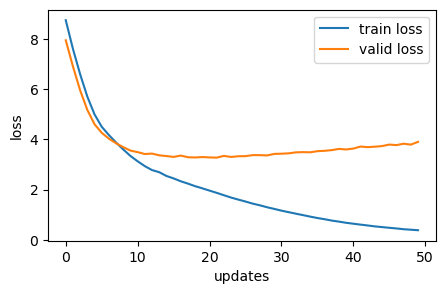

In [111]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [112]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.369 | Test PPL:  29.045 |


# 7) Inferences

### Sample 1 

In [166]:
sample = "import numpy as"

In [167]:
sample_text = text_transform(sample).to(device)
sample_text

tensor([  2,  22, 206,  73,   3], device='cuda:0')

In [168]:
sample_text = sample_text.reshape(1, -1)  #because batch_size is 1

In [169]:
sample_text.shape

torch.Size([1, 5])

In [170]:
text_length = torch.tensor([sample_text.size(0)]).to(dtype=torch.int64)

In [171]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output = model(sample_text) #turn off teacher forcing

In [172]:
output.shape

torch.Size([1, 5, 11754])

Since batch size is 1, we just take off that dimension

In [173]:
output = output.squeeze(0)

In [174]:
output.shape

torch.Size([5, 11754])

We shall remove the first token since it's zeroes anyway

In [175]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([4, 11754])

Then we just take the top token with highest probabilities

In [176]:
output_max = output.argmax(1) #returns max indices

In [177]:
output_max

tensor([ 5,  5, 12,  5], device='cuda:0')

In [178]:
mapping = vocab.get_itos()

In [179]:
for token in output_max:
    print(mapping[token.item()])

.
.
:
.


In [180]:
output_max

tensor([ 5,  5, 12,  5], device='cuda:0')

### Sample 2

In [181]:
sample = "from transformers import"

In [182]:
sample_text = text_transform(sample).to(device)
sample_text

tensor([  2,  27, 354,  22,   3], device='cuda:0')

In [183]:
sample_text = sample_text.reshape(1, -1)  #because batch_size is 1

In [184]:
sample_text.shape

torch.Size([1, 5])

In [185]:
text_length = torch.tensor([sample_text.size(0)]).to(dtype=torch.int64)

In [186]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output = model(sample_text) #turn off teacher forcing

In [187]:
output.shape

torch.Size([1, 5, 11754])

Since batch size is 1, we just take off that dimension

In [188]:
output = output.squeeze(0)

In [189]:
output.shape

torch.Size([5, 11754])

We shall remove the first token since it's zeroes anyway

In [190]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([4, 11754])

Then we just take the top token with highest probabilities

In [191]:
output_max = output.argmax(1) #returns max indices

In [192]:
output_max

tensor([ 5, 12,  5, 11], device='cuda:0')

In [193]:
mapping = vocab.get_itos()

In [194]:
for token in output_max:
    print(mapping[token.item()])

.
:
.
self


In [195]:
output_max

tensor([ 5, 12,  5, 11], device='cuda:0')